In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# HD143006 Tutorial Part 1

Here we are going to do the first step in real world data analysis with MPoL. We will gather the data and then produce a diagnostic image-- the MPoL Dirty Image. This image will have no RML methods applied to it, but it is still a good preliminary checkpoint. We will see the quality of this image and compare it to the DSHARP survey's image ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) created using the CLEAN method.

### Introduction to Regularized Maximum Likelihood (RML) Imaging

Regularized Maximum Likelihood (RML) imaging is a forward modeling methodology. We predict an image then represent it as an array of pixels. This is brought to the visibility domain through a forward Fourier transform. This is then compared to the measured data to ensure it is a viable predicted image. Due to information loss of the true image when obtaining the measured data, several predicted images- including incorrect ones- will match. To get to our best predicted image, we make new predictions by choosing the most likely (Maximum Likelihood) configuration and favoring specified criteria (Regularized). These criteria or regularizers, are chosen by the user. Some examples of favored criteria are smoothness and sparsity. The likeliness and how well a predicted image meet a certain criterion is mathematically represented in a loss function that contains hyperparameters used to weight data and regularizers. We minimize this loss function by performing a gradient descent, in which we adjust the pixel value intensities. Within this optimization run, hyperparameters are usually held fixed, but can be tuned between runs to produce a better image. When the loss function is minimized, our predicted image is at its best version to fit the collected data and follow our specified criterion.



### Loading Data

Let's load the data as we've done in previous tutorials. We will be examining the fiducial images (.fits) and extracted visibilities (.npz) of the HD143006 DSHARP survey. The extracted visibilities were calculated from the final (post-pipeline) calibrated measurement sets from DSHARP [here](https://mpol-dev.github.io/visread/) using visread.

*You can either download these two files (HD143006_continuum.fits and HD143006_continuum.npz) directly to your working directory, or use astropy to download them during run time.*



In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file

In [4]:
# downloading fits file
fname_F = download_file(
    "https://almascience.eso.org/almadata/lp/DSHARP/images/HD143006_continuum.fits",
    cache=True,
    pkgname="mpol",
)

In [5]:
# downloading extracted visibilities file
fname_EV = download_file(
    "https://zenodo.org/record/4904794/files/HD143006_continuum.npz",
    cache=True,
    pkgname="mpol",
)

Now that we have the files, let us examine the FITS image created by the DSHARP survey ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) using the CLEAN algorithm. First let's extract our data and then, to properly display the image, we will need to change from units of pixels to arcseconds. To do this, we will calculate the image extent.

In [6]:
# opening the fits file
dfits = fits.open(fname_F)
# getting the data from the fits file
clean_fits = dfits[0].data
header = dfits[0].header
# closing fits file
dfits.close()

In [7]:
# the following is to make axis scaling in arcsec (calculating the image extent)
# get the number of pixels in each direction
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # Convert from decimal scaling to arcsec
# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # [arcsec]
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]
# extent needs to include extra half-pixels.
# RA, DEC are pixel centers
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

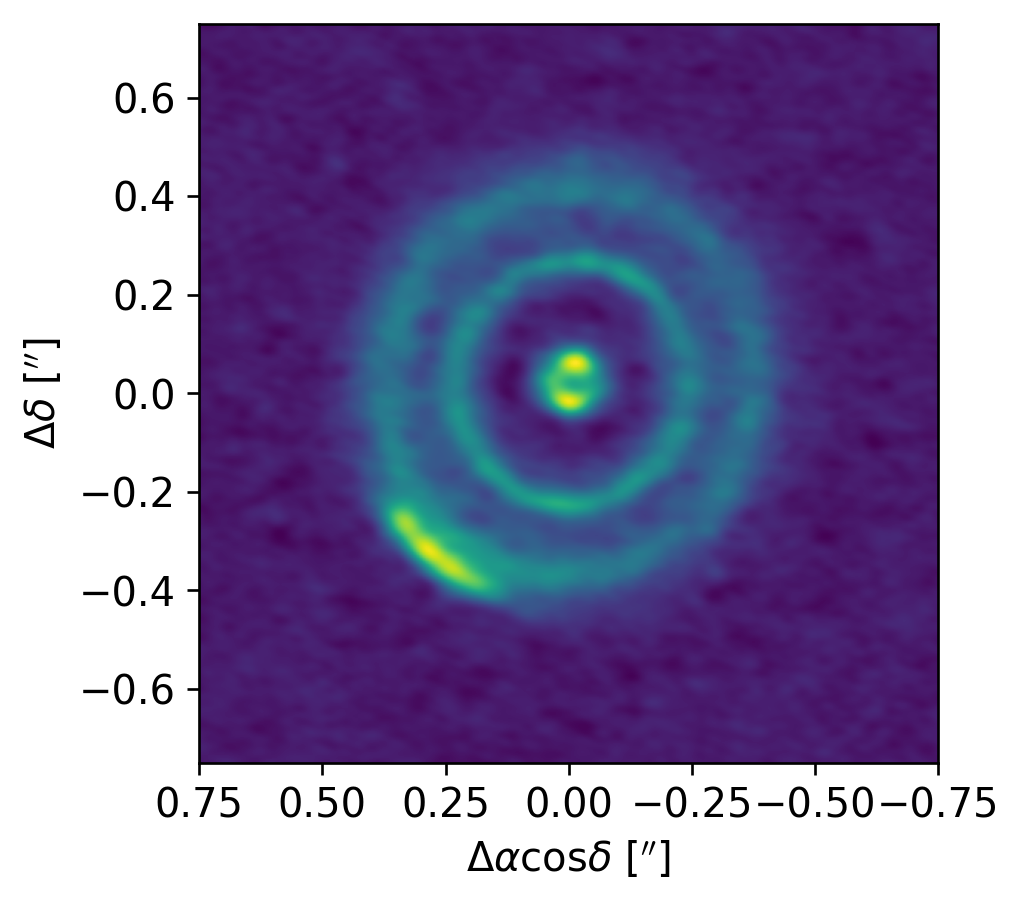

In [8]:
# plotting the clean fits
plt.imshow(np.squeeze(clean_fits), origin="lower", extent=ext)
# limiting the x and y axes so that we only plot the disk
plt.xlim(left=0.75, right=-0.75)
plt.ylim(top=0.75, bottom=-0.75)
# axis labels
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

This is the image produced by the CLEAN algorithm used by the DSHARP team ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)). In Part 1 of this tutorial we will be creating an MPoL Gridder object and the diagnostic dirty image. [**Part 2**](https://mpol-dev.github.io/MPoL/tutorials/HD143006_Part_2.html) of the tutorial will cover the optimization loop of the model to create the RML image.

To create the dirty image, we will use the extracted visibilities from the npz file and the MPoL Gridder and Coordinates packages.


In [9]:
# load extracted visibilities from npz file
dnpz = np.load(fname_EV)
uu = dnpz["uu"]
vv = dnpz["vv"]
weight = dnpz["weight"]
data = dnpz["data"]

### Plotting Visibilities
Let's quickly plot the $u,v$ coordinates of the visibilities as seen in the [Cross Validation Tutorial](https://mpol-dev.github.io/MPoL/tutorials/crossvalidation.html) and the [Visread docs](https://mpol-dev.github.io/visread/tutorials/introduction_to_casatools.html#Get-the-baselines).

Text(0.5, 1.0, '$U$, $V$ Visibilities')

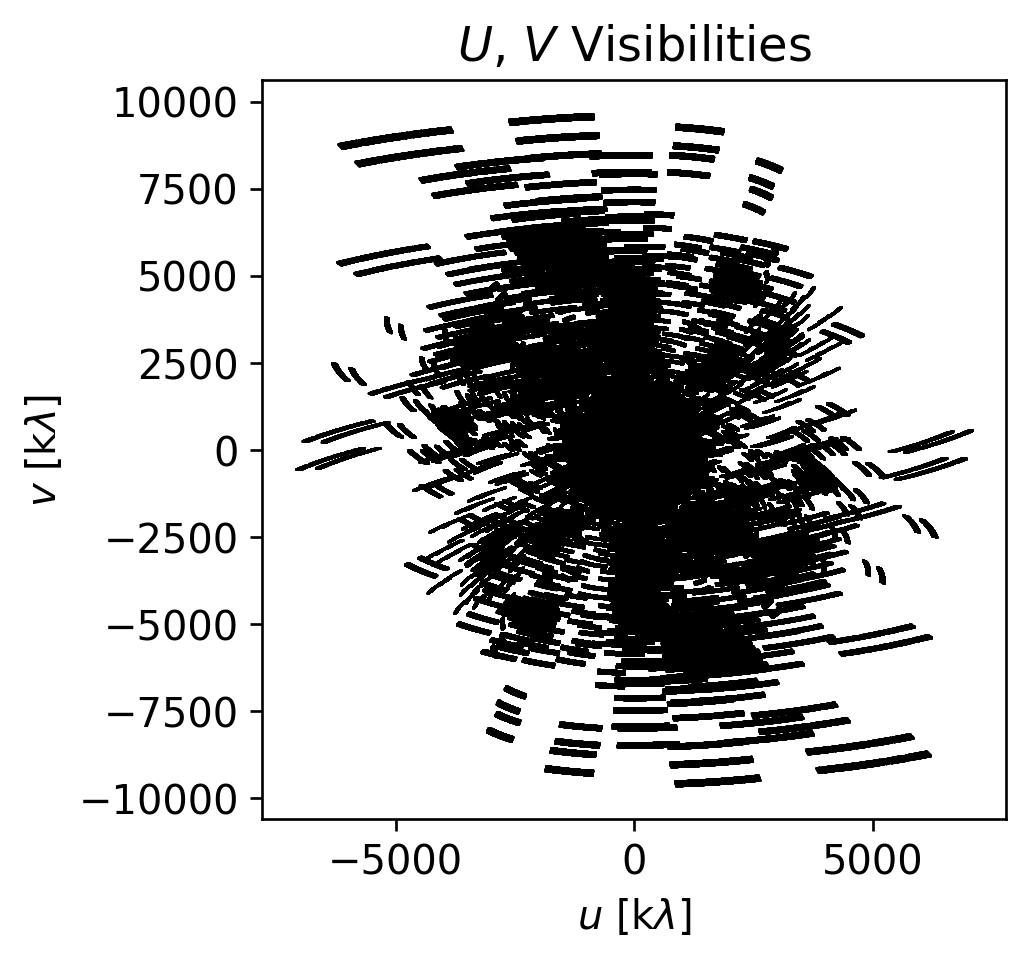

In [10]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(-uu, -vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title(r"$U$, $V$ Visibilities")

As you can see, there are very few visibilities > 7,000 ($k\lambda$), and a very dense region of visibilities between -2000 and 2000 ($k\lambda$). This indicates several groups of long-base visibilities at the higher frequencies while the bulk of our data stems from these lower frequencies.
### The Gridder Object
To create the MPoL Gridder object, we need a `cell_size` and the number of pixels in the width of our image, `npix`. You can read more about these properties in the [GridCoords](https://mpol-dev.github.io/MPoL/api.html#mpol.coordinates.GridCoords) API Documentation.  In the fits header we see our image is 3000x3000 pixels, so `npix=3000`. Getting our cell size in terms of arcseconds is a bit more tricky. Our fits image has a header called `CDELT1` which is the scaling in degrees. To get this into arcseconds we multiply by 3600. We save this as `cdelt_scaling`. `cdelt_scaling` can be negative, and cell_size must be positive so we will take the absolute value of this.

In [11]:
# opening the fits file
dfits = fits.open(fname_F)
# printing out the header info
dfits.info()

Filename: /Users/ian/.mpol/cache/download/url/3e5b682bb9f1ea6e13cfe13e03d1170e/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      80   (3000, 3000, 1, 1)   float32   


In [12]:
cdelt_scaling = dfits[0].header["CDELT1"] * 3600  # scaling [arcsec]
cell_size = abs(cdelt_scaling)  # [arcsec]
# closing fits file
dfits.close()

In [13]:
from mpol import coordinates, gridding

In [14]:
# creating Gridder object
coords = coordinates.GridCoords(cell_size=cell_size, npix=512)
gridder = gridding.Gridder(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,  # separating the real and imaginary values of our data
    data_im=data.imag,
)

We now have everything we need to get the MPoL dirty image. No RML methods will be applied in Part 1 of this tutorial. Here we are using [Gridder.get_dirty_image()](../api.rst#mpol.gridding.Gridder.get_dirty_image) to average the visibilities to the grid defined by gridder and from there we get our dirty image and dirty beam. There are different ways to average the visibilities, called weighting, and here we use Uniform and Briggs weighting to find and produce a dirty image that resembles the CLEAN image. More info on the weighting can be read in the [CASA documentation](https://casa.nrao.edu/casadocs-devel/stable/imaging/synthesis-imaging/data-weighting). For the Briggs weighting, we will use three different values for the `robust` variable. This dictates how aggresive our weight scaling is towards image resolution or image sensitivity.

*Note: Briggs weighting with `robust=-2.0` is similar to uniform weighting.

Now let's make a plotting function to show us the MPoL dirty image. If you have read through other MPoL tutorials, then this code should look familiar. We are going to plot all four of the different weightings, so creating a plotting function simplifies our code a lot.

In [15]:
def plot(img, imtitle="image"):
    kw = {"origin": "lower", "extent": gridder.coords.img_ext}
    fig, ax = plt.subplots(ncols=1)
    im = ax.imshow(np.squeeze(img), **kw)
    plt.colorbar(im)
    ax.set_title(imtitle)
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    plt.xlim(left=0.75, right=-0.75)
    plt.ylim(bottom=-0.75, top=0.75)

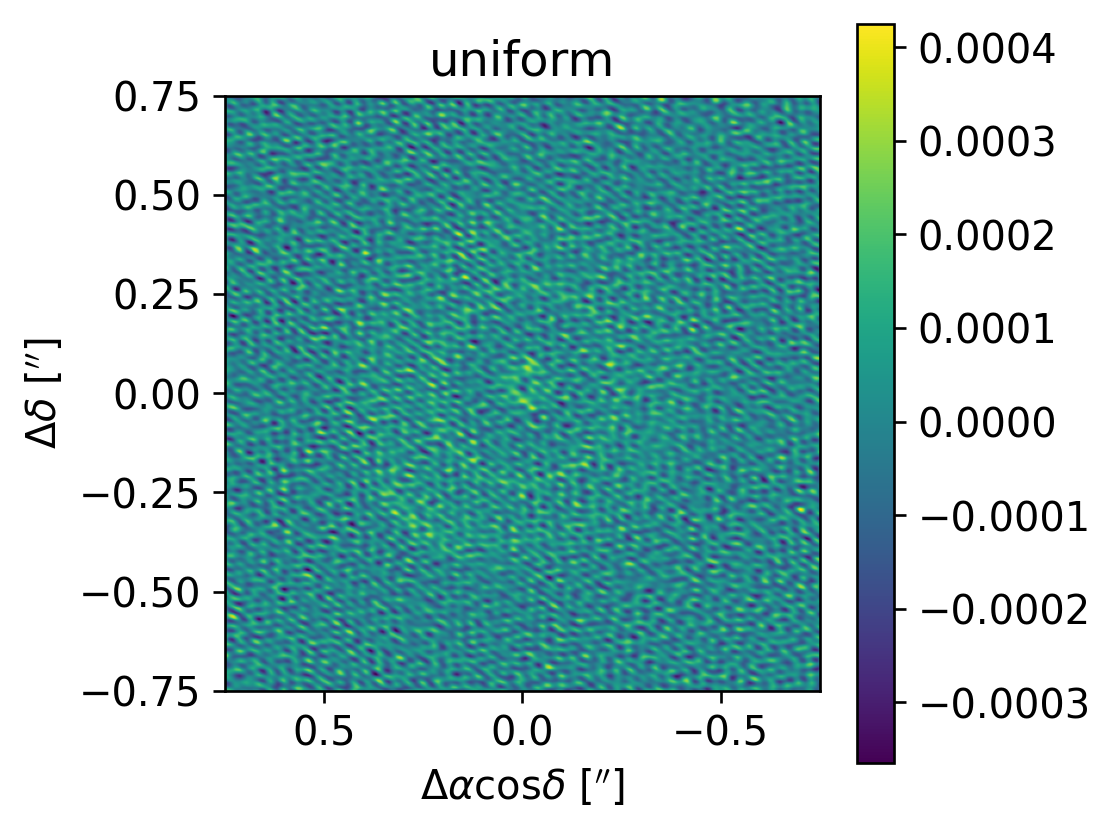

In [16]:
img, beam = gridder.get_dirty_image(weighting="uniform")
plot(img, imtitle="uniform")

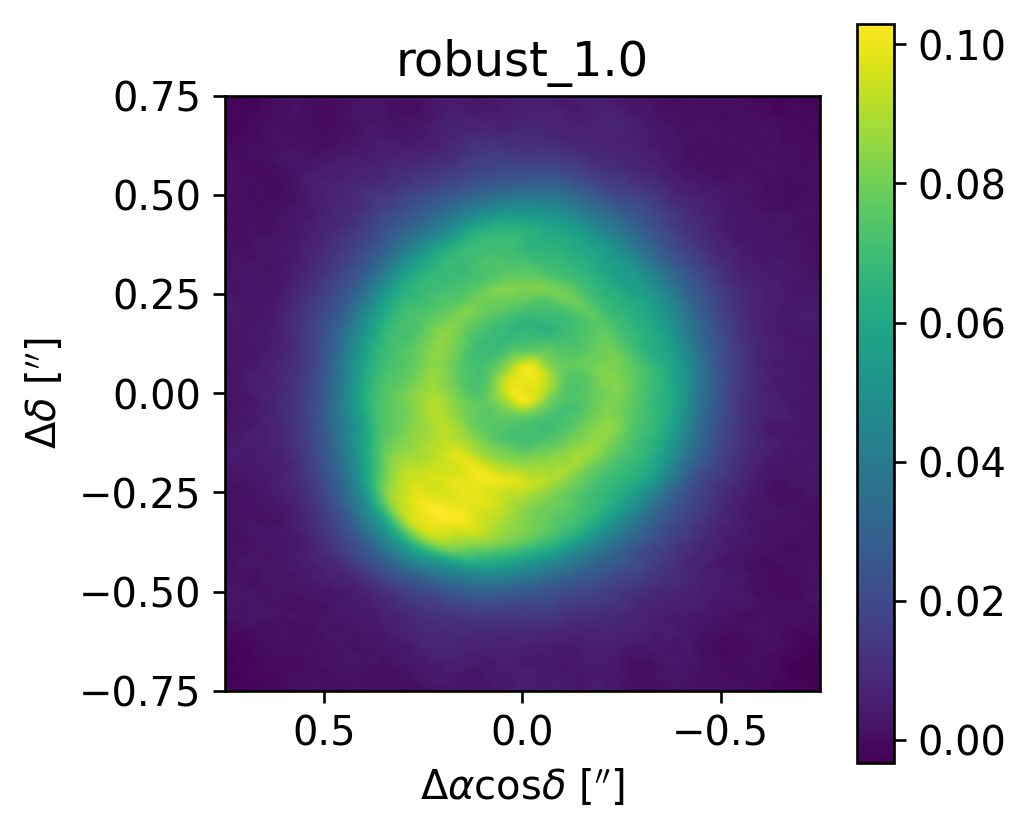

In [17]:
img, beam = gridder.get_dirty_image(weighting="briggs", robust=1.0, unit="Jy/arcsec^2")
plot(img, imtitle="robust_1.0")

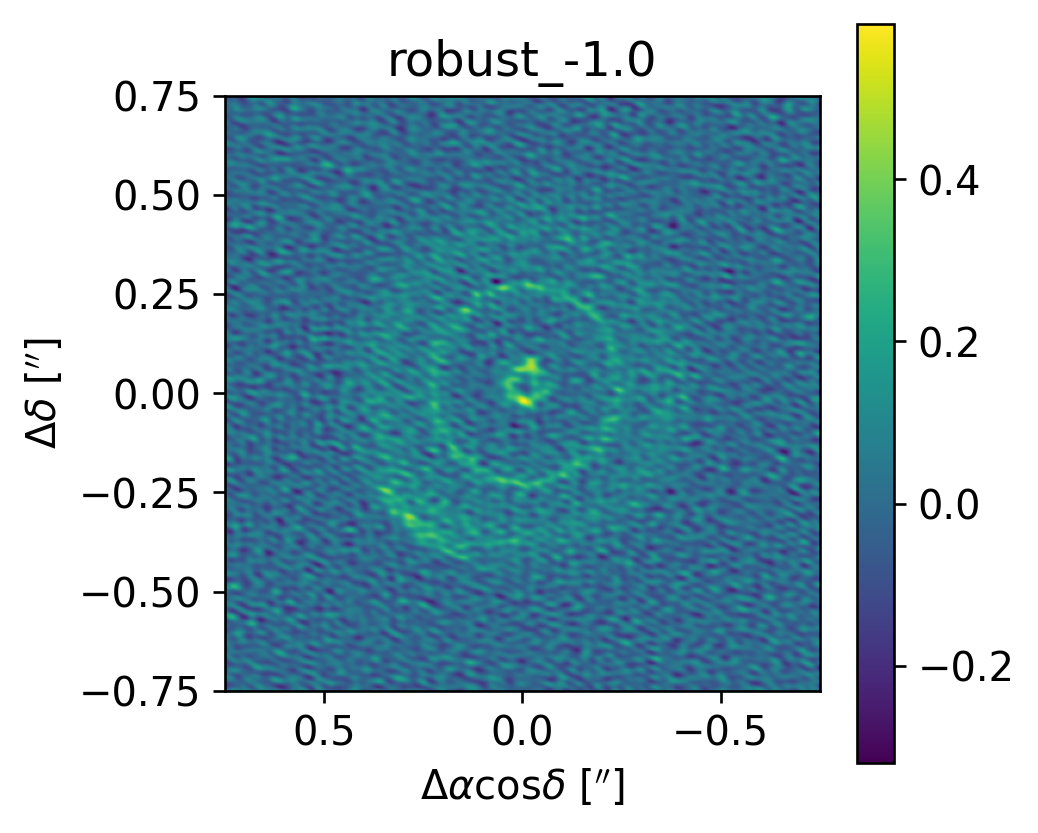

In [18]:
img, beam = gridder.get_dirty_image(weighting="briggs", robust=-1.0, unit="Jy/arcsec^2")
plot(img, imtitle="robust_-1.0")

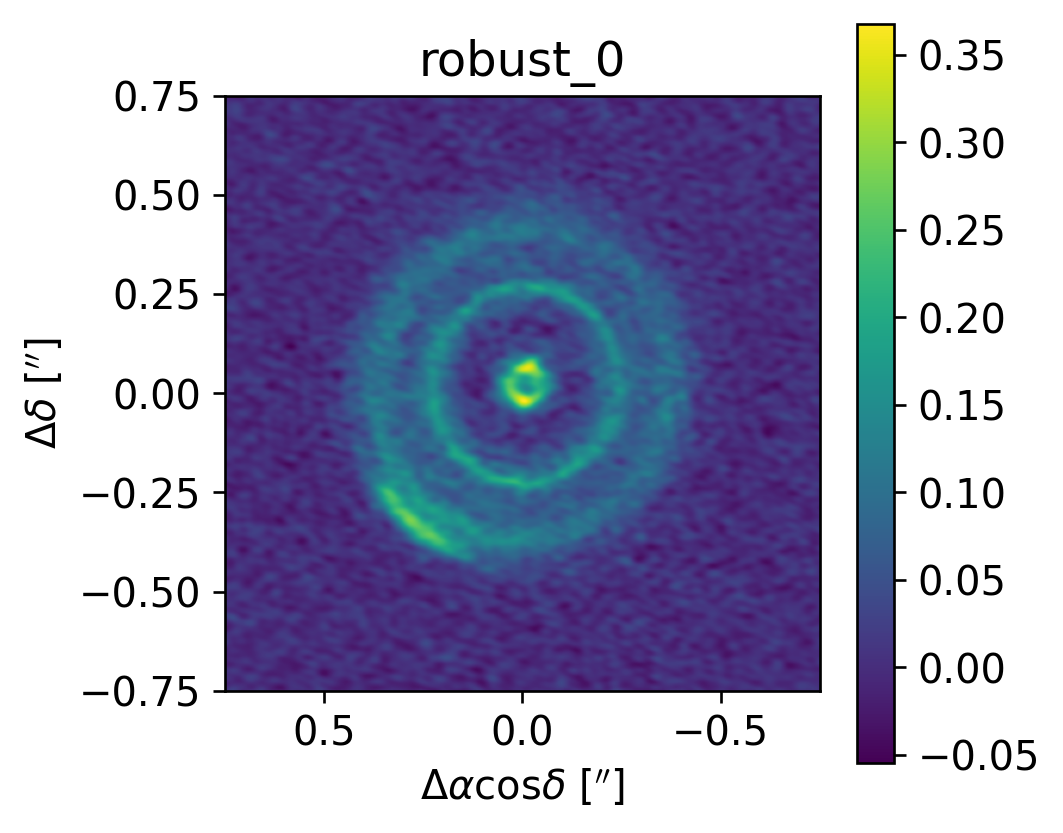

In [19]:
img, beam = gridder.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")
plot(img, imtitle="robust_0")

## Comparing Dirty Image to CLEAN Algorthim
Below we plot the DSHARP CLEAN image alongside the MPoL Dirty Image weighted with the Briggs scale and `robust=0.0` for comparison.

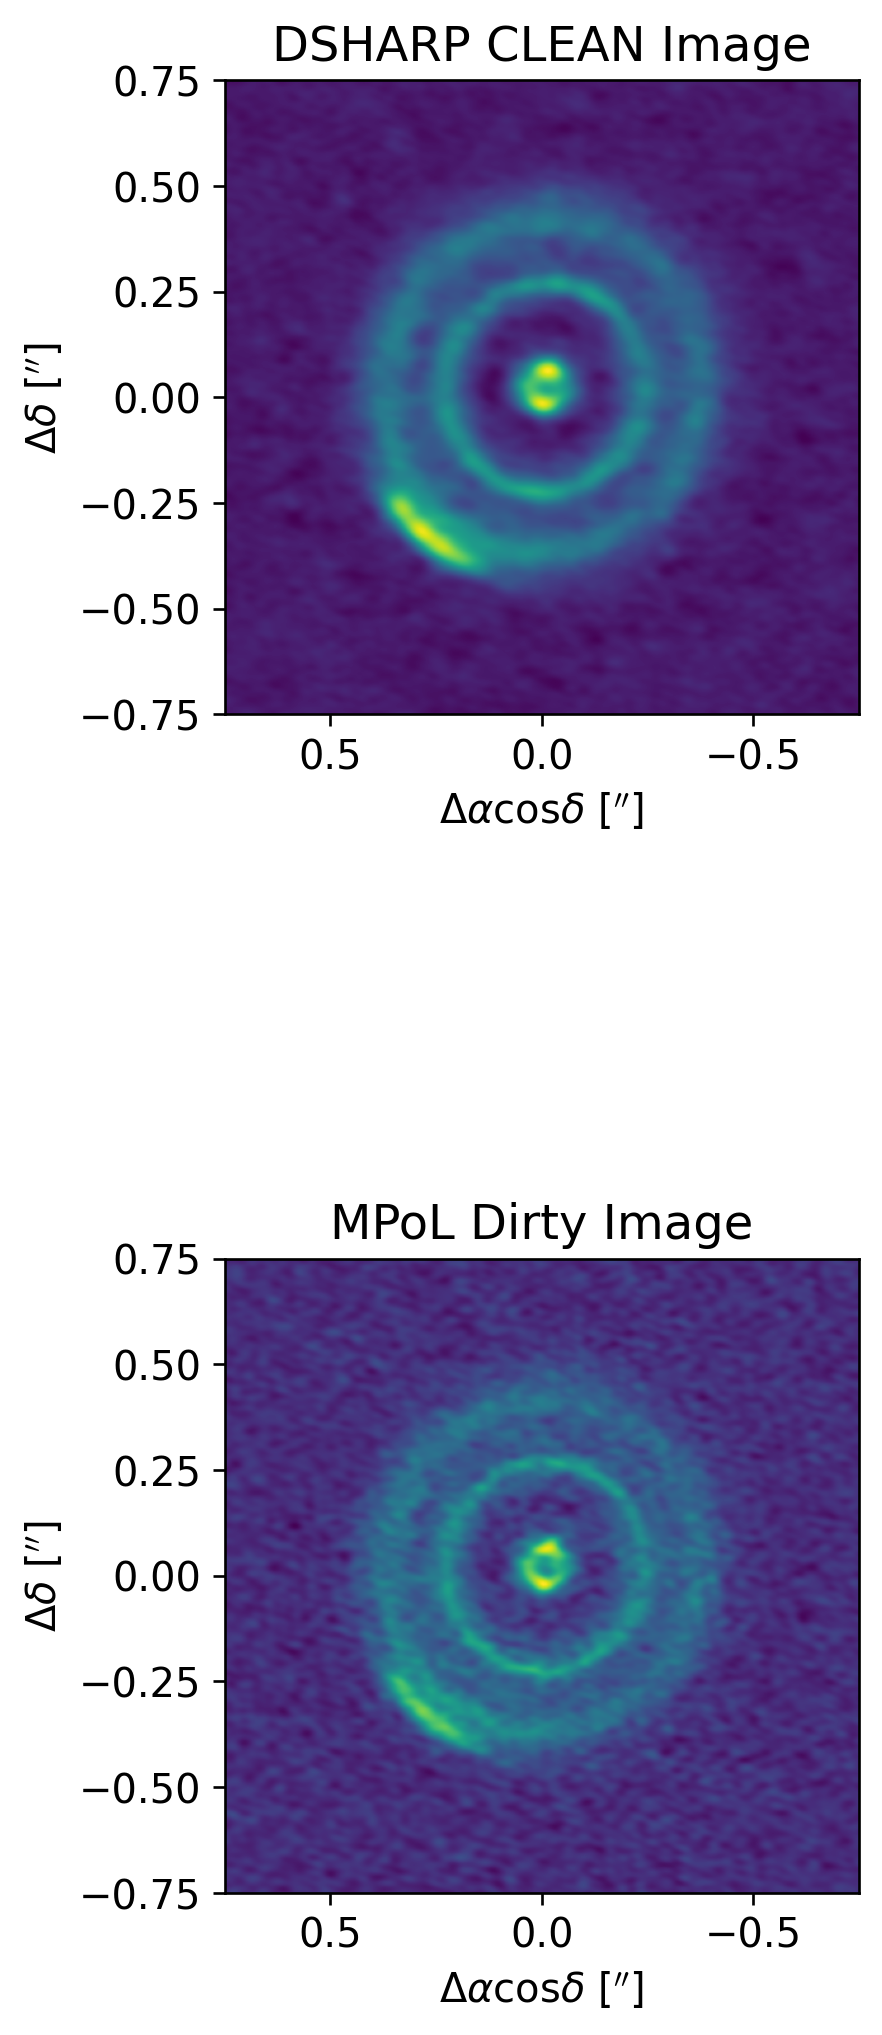

In [20]:
kw = {"origin": "lower", "extent": gridder.coords.img_ext}
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(np.squeeze(clean_fits), origin="lower", extent=ext)
ax[0].set_xlim(left=0.75, right=-0.75)
ax[0].set_ylim(bottom=-0.75, top=0.75)
ax[0].set_title("DSHARP CLEAN Image")
ax[0].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[0].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax[1].imshow(np.squeeze(img), **kw)
ax[1].set_title("MPoL Dirty Image")
ax[1].set_xlim(left=0.75, right=-0.75)
ax[1].set_ylim(bottom=-0.75, top=0.75)
ax[1].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[1].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
fig.set_figheight(10)
plt.tight_layout()

As you can see there are many similarities between the diagnostic dirty image and the image produced using the CLEAN algorithm by the DSHARP survey ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)). While the dirty image is more noisy, it still maintains many distinct features present in the CLEAN image. For example, you can clearly see the different rings and make out the asymmetry found in the bottom left corner of the images. Also, the overall intensities of points are very similar, where something is a bright green in the DSHARP image, a very similar level is found in the Dirty Image. One of the main differences between the two images is the sharpness of pixels. Visually, the DSHARP image has a smeared look to it while the dirty image has a clearer, grainy look to it. This difference stems from the CLEAN algorithm attempting to smooth pixels and create a clean image while we have not applied any imaging techniques to the MPoL image thus far. In the next part of the HD143006 tutorial, we will be increasing the quality of the diagnostic dirty image using RML through MPoL, Optimization, and Cross Validation with help from [PyTorch](pytorch.org).
